# Dependencies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('digits.csv')

In [3]:
data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<h1>Data Preprocessing</h1>

Train and test Splitting

In [4]:
# write a function that one hot encodes the labels for the training data
def one_hot(labels, num_classes=10):
    # use the identity matrix and the label to place the 1 in the relevant spot
    return np.eye(num_classes)[labels]

In [5]:
def prepare_train_data():
    
    
    # use the first forty thousand entries from the 
    training_data = data.loc[0:40000]
    X_train = training_data.drop(columns = "label")
    # dividing by 255 is done in order to scale all of the pixel values down to a value between 0 and 1
    X_train = X_train / 255
    y_train_label = training_data["label"]

    # converting my DataFrames into arrays is what strips the data of the things like indexes and column names
    X_train = np.array(X_train)
    m,n = X_train.shape
    y_train = np.array(y_train_label)
    # one hot encode the labels
    y_train = one_hot(y_train)
    

    return X_train,y_train,y_train_label


In [7]:
X_train,y_train,y_train_label = prepare_train_data()

In [8]:
X_train.shape

(40001, 784)

In [9]:
y_train.shape

(40001, 10)

In [10]:
def prepare_test_data():
    
    # for the test data we are going to use the remaining entries
    testing_data = data.loc[40000:42000]
    X_test = testing_data.drop(columns="label")
    
    # scale pixel values down to the 0,1 range
    X_test = X_test / 255
    y_test_label = testing_data["label"]

    # strip the data down
    X_test = np.array(X_test)
    y_test = np.array(y_test_label)
    # one hot encode the labels
    y_test = one_hot(y_test)

    return X_test,y_test,y_test_label

<h1> Neural Network Architecture </h1>

Layers, nodes, weights and biases.

In [11]:
def init_params():
    
    # nodes per layer there are 784 in the input for the amount of pixels and 10 output nodes (one for each digit 0-9)
    n = [784,10,10]
    
    # randomly initialize the weights for the first layer
    # He initialization scales the weights accord to the number of inputs for each layer
    w1 = np.random.randn(n[1],n[0]) * np.sqrt(2. / n[0])
    
    w2 = np.random.randn(n[2],n[1]) *  np.sqrt(2. / n[1])
    
    # biases offset the weighted sum of the inputs, since they are not scaling activations, only shifting them
    b1 = np.random.randn(n[1],1)
    
    b2 = np.random.randn(n[2],1)

    return w1,b1,w2,b2


Activation functions

In [12]:
def relu(z):
    # if the input of this function is positive, it is returned.  if not it returns 0
    # introduces non-linearity
    return np.maximum(z,0)

def d_relu(z):
    # this returns 1 if the input is greater than 0, returns 0 otherwise
    # the derivative of relu is used during backpropagation
    return (z > 0).astype(np.float32)

In [13]:
def softmax(Z):
    # this will convert a matrix into a probability distribution that sums to 1
    A = np.exp(Z) / sum(np.exp(Z))
    return A

def d_soft(A2, y_train):
    # the gradient for softmax and cross-entropy loss simplifies to the difference of the predicted output A2 and the true label
    # the derivative of softmax is used during backprop
    return A2 - y_train 


Cross Entropy Loss Function for Multiple Classes

In [14]:
def categorical_crossentropy_loss(y_train, y_hat):
    # clipping is done to avoid y_hat being equal to exactly 0 or 1 which would cause problems when taking logs
    y_hat = np.clip(y_hat, 1e-10, 1 - 1e-10)
    # the number of instances in the training data
    m = y_train.shape[0]
    # loss measures how wrong the neural network is across a batch of samples
    # this function is also convex which means it has a global minimum, this is helpful during gradient descent
    loss = -np.sum(y_train.T * np.log(y_hat))/m
    
    return loss

Forward Propagation

In [15]:
def forward_prop(X_train,w1,b1,w2,b2):
    
    # A0 represents the input layer, it is tranposed so it matches the dimensions of the next layer
    A0 = X_train.T
    
    # the data in the input layer is passed through the first layer by being scaled by weight 1 and shifted by bias 1
    z1 =  np.dot(w1,A0) + b1
    
    # we get A1 by passing z1 through the relu function which is the first step in the network learning patterns
    A1 = relu(z1)

    # A1 is passed through the second layer by being scaled by weight 2 and shifted by bias 2
    z2 = np.dot(w2,A1) + b2
    
    # softmax converts our z2 matrix into a probability distribution for each class (digits 0-9)
    A2 = softmax(z2)
    
    # this information is stored in a cache so it can be updated during backpropagation
    cache = {"A0" :A0,
             "A1" : A1,
             "A2" : A2 ,
             "z2" : z2,
             "z1" : z1}
    
    return cache


Back Propagation

In [16]:
def back_prop(X_train,y_train,cache,w1,b1,w2,b2,alpha=0.01,m=X_train.shape[0]):
    
    
    # extract the values from the cache
    A0 = cache["A0"]
    A1 = cache["A1"]
    A2 = cache["A2"]
    z1 = cache["z1"]
    z2 = cache["z2"]

    # derivative of loss with respect to z2
    da2 = d_soft(A2,y_train.T)
    dz2 = da2

    # derivative of loss with respect to w2 and b2
    dw2 = np.dot(dz2,A1.T)/m
    db2 = np.sum(dz2,axis=1,keepdims=True)/m

    # derivative of loss with respect to a1 and z1
    da1 = np.dot(w2.T,dz2)
    dz1 = da1 * d_relu(z1)

    # derivative of loss with respect to w1 and b1
    dw1 = np.dot(dz1,A0.T)/m
    db1 = np.sum(dz1,axis=1,keepdims = True)/m

    
    
    # update the weights and biases (gradient descent)
    w1 -= alpha * dw1  
    b1 -= alpha * db1  
    w2 -= alpha * dw2  
    b2 -= alpha * db2  
    

    # store the gradients inside a cache
    gradients = {
        "dW1": dw1,
        "db1": db1,
        "dW2": dw2,
        "db2": db2
    }

    return w1, b1, w2, b2, gradients




The training function

In [17]:
def train(X_train, y_train, num_epochs=1500, alpha=0.15, hidden_size=10, output_size=10):
    
    
    input_size = X_train.shape[0]  
    m = X_train.shape[1] 

    
    w1, b1, w2, b2 = init_params()
    losses =[]
    
    for epoch in range(num_epochs):
        
        # feed forward the data
        cache = forward_prop(X_train, w1, b1, w2, b2)

        # call the predictions
        A2 = cache["A2"]

        # calculate the loss of the model
        loss = categorical_crossentropy_loss(y_train, A2)
        
        # store this loss in a list
        losses.append(loss)

        # use backpropagation to updaye the weights and biases
        w1, b1, w2, b2, gradients = back_prop(X_train, y_train, cache, w1, b1, w2, b2, alpha)

        
        if epoch % 100 == 0:
            print(f"Epoch {epoch}/{num_epochs}, Loss: {loss:.4f}")
            
    # store the trained weights and biases in a dictionary called model
    model = {"w1" : w1,
               "w2" : w2,
               "b1" : b1,
               "b2" : b2}
    
    return model,losses


A script that builds the model.

In [18]:
X_train,y_train,y_train_label = prepare_train_data()

model_cache,errors = train(X_train,y_train)

Epoch 0/1500, Loss: 3.0079
Epoch 100/1500, Loss: 0.5434
Epoch 200/1500, Loss: 0.4046
Epoch 300/1500, Loss: 0.3578
Epoch 400/1500, Loss: 0.3350
Epoch 500/1500, Loss: 0.3212
Epoch 600/1500, Loss: 0.3117
Epoch 700/1500, Loss: 0.3046
Epoch 800/1500, Loss: 0.2989
Epoch 900/1500, Loss: 0.2940
Epoch 1000/1500, Loss: 0.2898
Epoch 1100/1500, Loss: 0.2862
Epoch 1200/1500, Loss: 0.2830
Epoch 1300/1500, Loss: 0.2800
Epoch 1400/1500, Loss: 0.2774


In [19]:
model_cache.keys()

dict_keys(['w1', 'w2', 'b1', 'b2'])

<h1> Making Predictions </h1>

In [20]:
def model_predict(X, model_cache):
    
    # extract the trained weights and biases from the model
    w1 = model_cache["w1"]
    b1 = model_cache["b1"]
    w2 = model_cache["w2"]
    b2 = model_cache["b2"]
    
    # feed the data through the trained weights and biases
    A0 = X.T
    z1 = np.dot(w1, A0) + b1  
    A1 = relu(z1)  
    
    z2 = np.dot(w2, A1) + b2  
    A2 = softmax(z2)  

    # call the index with the highest value to get the predicted class
    predictions = np.argmax(A2, axis=0)
    
    return predictions

In [21]:
def image_predict(image,model_cache):

    # this is essentially the same function as above except its for a single image, not a batch
    w1 = model_cache["w1"]
    b1 = model_cache["b1"]
    w2 = model_cache["w2"]
    b2 = model_cache["b2"]

    
    image = image.reshape(1,-1)

    
    A0 = image.T  
    z1 = np.dot(w1, A0) + b1 
    A1 = relu(z1)  
    
    z2 = np.dot(w2, A1) + b2  
    A2 = softmax(z2)  

    
    image_prediction = np.argmax(A2, axis=0)  
    
    return image_prediction[0]


<h1> Model Perfomance </h1>

In [22]:
def performance_metrics(X_test,y_test,y_test_label):
    

    # load all of the models predictions for the test data into a dataframe
    y_pred = model_predict(X_test,model_cache)
    y_pred = pd.DataFrame(y_pred)
    y_pred.rename(columns = {0 : "prediction"},inplace=True)

    # load the actual labels into another dataframe
    y_actual = pd.DataFrame(y_test_label)
    y_actual.rename(columns = {"label" : "actual"},inplace=True)
    y_actual.reset_index(drop=True,inplace=True)

    # concat these two dataframe so we can run comparisions
    compare_df = pd.concat([y_pred,y_actual],axis=1)
    compare_df["correct"] = compare_df["prediction"] == compare_df["actual"]

    # count the amount that the model got correct and get a score
    amount_correct = compare_df["correct"].sum(axis=0)
    accuracy = amount_correct/len(compare_df)

    return compare_df,accuracy
    

In [23]:
X_test,y_test,y_test_label = prepare_test_data()

compare_df,accuracy = performance_metrics(X_test,y_test,y_test_label)

In [24]:
print("accuracy:",accuracy)

accuracy: 0.909


In [25]:
compare_df

,prediction,actual,correct
0,2,2,True
1,3,3,True
2,3,9,False
3,7,7,True
4,8,8,True
...,...,...,...
1995,0,0,True
1996,1,1,True
1997,7,7,True
1998,6,6,True


Plotting the Cost

In [26]:
def plot_cost(error_list,iterations=range(1,1501)):
    plt.plot(iterations,errors)
    plt.xlabel('Epochs')
    plt.ylabel("Cost")
    plt.title("Cost over Epochs")
    plt.show()

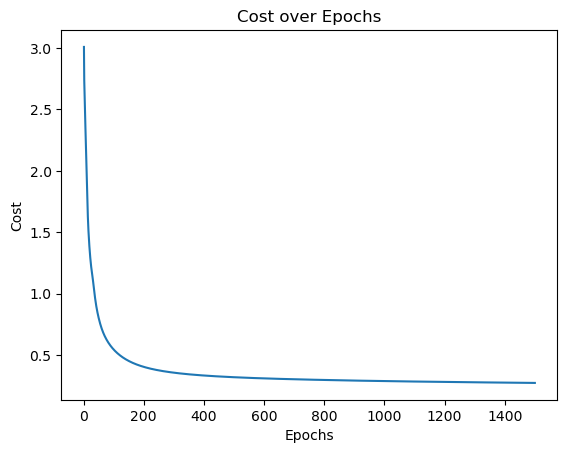

In [27]:
plot_cost(errors)

<h1> Model Serialization </h1>

In [28]:
import pickle

Inside the pickle I want the model, the feed forward function, and accuracy metrics.

In [29]:
model_cache

{'w1': array([[-0.01976538, -0.00628602,  0.03579461, ...,  0.11042308,
          0.10854866,  0.06685476],
        [-0.04957384,  0.03427966, -0.03059694, ..., -0.03409137,
          0.02346369,  0.07549176],
        [ 0.0200878 , -0.00504093, -0.09223921, ...,  0.01652161,
         -0.02925595,  0.04863751],
        ...,
        [ 0.02340058,  0.0279786 , -0.04539013, ..., -0.01761576,
         -0.06917253,  0.01868866],
        [ 0.00596805, -0.00891449, -0.02228728, ..., -0.13032353,
          0.0724771 ,  0.01854952],
        [ 0.00706435, -0.06265492, -0.02599506, ..., -0.07615633,
         -0.00993424, -0.07566356]]),
 'w2': array([[-0.10139382, -0.35689657, -1.53709545,  0.57648151,  0.3425518 ,
          0.17327409,  0.0264326 ,  0.99997942,  0.79636988, -1.3203323 ],
        [ 0.37122248, -0.51682807,  0.63313527, -0.15672574, -0.86316698,
         -0.73633264,  0.62688197, -1.22978173,  0.5959038 ,  0.83572044],
        [-0.01841488, -0.00631948,  0.41734517,  0.30323806,  1

In [30]:
digit_recognizer = {
    "digit_model" : model_cache,
    "costs" : errors,
    "compare_df" : compare_df,
    "accuracy" : accuracy
}


In [31]:
# Saving the object to a pickle file
with open('digit_recognizer.pkl', 'wb') as f:
    pickle.dump(digit_recognizer, f)